In [4]:
import os
import tensorflow as tf
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Layer, Dense, LayerNormalization, Dropout,Flatten
from keras.models import Model,Sequential
from keras import Input
import visualkeras
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import RootMeanSquaredError
from keras.callbacks import TensorBoard


gpus = tf.config.list_physical_devices('GPU')
if gpus:
	try:
		for gpu in gpus:
			tf.config.experimental.set_memory_growth(gpu,True)
		logical_gpus = tf.config.list_logical_devices('GPU')
		print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} logical GPUs')
	except RuntimeError as e:
		print(f"error setting up gpus: {e}")
else:
	print('no gpus')
class MultiHeadSelfAttention(Layer):
	def __init__(self,embed_dim,num_heads = 8):
		super(MultiHeadSelfAttention,self).__init__()
		self.embed_dim = embed_dim
		self.num_heads = num_heads
		self.projection_dim = embed_dim//num_heads
		self.query_dense = Dense(embed_dim)
		self.key_dense= Dense(embed_dim)
		self.value_dense= Dense(embed_dim)
		self.combine_heads = Dense(embed_dim)
	def attention(self,query,key,value):
		score = tf.matmul(query,key,transpose_b = True)
		dim_key = tf.cast(tf.shape(key)[-1],tf.float32)
		scaled_score = score/tf.math.sqrt(dim_key)
		weights = tf.nn.softmax(scaled_score,axis=-1)
		output = tf.matmul(weights,value)
		return output,weights
	def split_heads(self,x,batch_size):
		x = tf.reshape(x,(batch_size,-1,self.num_heads,self.projection_dim))
		return tf.transpose(x,perm=[0,2,1,3])
	def call(self,inputs):
		batch_size = tf.shape(inputs)[0]
		query = self.query_dense(inputs)
		key = self.key_dense(inputs)
		value = self.value_dense(inputs)
		query = self.split_heads(query,batch_size)
		key = self.split_heads(key,batch_size)
		value = self.split_heads(value,batch_size)
		attention_output,_=self.attention(query,key,value)
		attention_output = tf.transpose(attention_output,perm=[0,2,1,3])
		concat_attention = tf.reshape(attention_output,(batch_size,-1,self.embed_dim))
		return self.combine_heads(concat_attention)
class TransformBlock(Layer):
	def __init__(self,embed_dim,num_heads,ff_dim,rate=0.1):
		super(TransformBlock,self).__init__()
		self.att = MultiHeadSelfAttention(embed_dim,num_heads)
		self.ffn = Sequential([Dense(ff_dim,activation='relu'),Dense(embed_dim),])
		self.layernorm1 = LayerNormalization(epsilon = 1e-6)
		self.layernorm2 = LayerNormalization(epsilon=1e-6)
		self.dropout1 = Dropout(rate)
		self.dropout2 = Dropout(rate)
	def call(self,inputs,training=False):
		attn_output = self.att(inputs)
		attn_output = self.dropout1(attn_output,training=training)
		out1 = self.layernorm1(inputs+attn_output)
		ffn_output = self.ffn(out1)
		return self.layernorm2(out1+ffn_output)
class TransformerEncoder(Layer):
	def __init__(self,num_layers,embed_dim,num_heads,ff_dim,rate=0.1):
		super(TransformerEncoder,self).__init__()
		self.enc_layers = [TransformBlock(embed_dim,num_heads,ff_dim) for _ in range(num_layers)]
		self.dropout = Dropout(rate)
	def call(self,inputs,training=False):
		x = inputs
		x = self.dropout(x,training=training)
		for layer in self.enc_layers:
			x = layer(x,training=training)
		return x
def create_dataset(data,time_step=1):
	X,Y = [],[]
	for i in range(len(data)-time_step-1):
		X.append(data[i:(i+time_step)])
		Y.append(data[(i+time_step),2])
	return np.array(X),np.array(Y)
def build_model(time_step,embed_dim=128,num_heads=8,ff_dim = 512,num_layers=4,dropout_rate=0.1):
	inputs = Input(shape=(time_step,3))
	x = Dense(embed_dim)(inputs)
	encoder = TransformerEncoder(num_layers,embed_dim,num_heads,ff_dim,rate=dropout_rate)
	x = encoder(x)
	x = Flatten()(x)
	x = Dropout(dropout_rate)(x)
	outputs = Dense(1)(x)
	return Model(inputs,outputs)
	
def main():
	np.random.seed(42)
	data_length = 3000
	trend1 = np.linspace(0,365,data_length)
	trend2 = np.linspace(0,2,data_length)
	trend3 = np.linspace(0,38,data_length)
	#trend1 = np.sin(trend1)
	#trend2 = np.linspace(40,80,data_length)
	noise = np.random.normal(0,1,data_length)
	synthetic_data1 = trend1+noise
	synthetic_data2 = trend2+noise
	synthetic_data3 = trend3+noise
	df = pd.DataFrame()
	df['Time'] = synthetic_data1
	df['keff'] = synthetic_data2
	df['cr_pos'] = synthetic_data3
	
	print(df.head())
	scaler = MinMaxScaler(feature_range=(0,1))
	scaler2 = MinMaxScaler(feature_range=(0,1))
	scaled_data = scaler.fit_transform(df[['Time','keff','cr_pos']].values)
	scaled_data2 = scaler2.fit_transform(df[['cr_pos']].values)
	time_step = 100
	X,Y = create_dataset(scaled_data,time_step)
	print(X.shape,Y.shape)
	X = X.reshape((X.shape[0],X.shape[1],3))
	model = build_model(time_step,embed_dim=128,num_heads=8,ff_dim=512,num_layers=4,dropout_rate = 0.1)
	model.compile(optimizer='Adam',loss='mse',metrics=['mae',RootMeanSquaredError(name='rmse')])
	model.summary()
	logdir = os.path.join("logs",datetime.now().strftime("%Y%m%d-%H%M%S"))
	os.makedirs(logdir,exist_ok=True)
	arch_path = os.path.join(logdir,'model_visualkeras.png')
	visualkeras.layered_view(model,to_file=arch_path,legend=True,draw_volume=False,scale_xy=1.5,scale_z=1,spacing=20)
	with tf.summary.create_file_writer(logdir).as_default():
		img = tf.io.read_file(arch_path)
		img = tf.image.decode_png(img,channels=4)
		tf.summary.image("Model_visualization",tf.expand_dims(img,0),step=0)
	tensorboard_cb = TensorBoard(log_dir = logdir,histogram_freq = 1,write_graph=True,write_images=True,update_freq='epoch',profile_batch=1)
	print(f"Tensorboard logs in : {os.path.abspath(logdir)}")
	print(f"Run: tensorboard--logdir{logdir}")
	history = model.fit(X,Y,epochs=20,batch_size = 32,validation_split=0.1,callbacks = [tensorboard_cb])
	loss = model.evaluate(X,Y)
	print(X.shape)
	#print("Test loss (MSE): {:.6f}".format(loss))
	predictions = model.predict(X)
	print(predictions.shape)
	prediction = predictions.flatten()
	predictions = scaler2.inverse_transform(predictions)
	plt.figure(figsize=(10,6))
	plt.plot(df['keff'],df['cr_pos'],label='True data')
	plt.plot(X[0],predictions,label = 'Predictions')
	plt.title('Transformer Time Series Forecasting')
	plt.xlabel('Time')
	plt.ylabel('synthetic data')
	plt.legend()
	plot_path=os.path.join(logdir,'prediction_plot.png')
	plt.savefig(plot_path,dpi=300,bbox_inches='tight')
	print(f"Plot saved to: {plot_path}")
	
if __name__=='__main__':
	main()

2025-07-29 20:03:37.571737: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-29 20:03:37.583160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753797817.595990   67755 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753797817.599720   67755 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-29 20:03:37.614008: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

InternalError: cudaSetDevice() on GPU:0 failed. Status: CUDA-capable device(s) is/are busy or unavailable

1 Physical GPUs, 1 logical GPUs
       Time      keff    cr_pos
0  0.496714  0.496714  0.496714
1 -0.016557 -0.137597 -0.125593
2  0.891103  0.649022  0.673030
3  1.888152  1.525031  1.561043
4  0.252676 -0.231486 -0.183470
(2899, 100, 3) (2899,)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 100, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 100, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,401 (3.08 MB)

 Trainable params: 806,401 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

Tensorboard logs in : /home/mechaquanta/logs/20250729-211137
Run: tensorboard--logdirlogs/20250729-211137
Epoch 1/20


/home/mechaquanta/miniconda3/envs/project/lib/python3.9/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
2025-07-29 21:11:37.311928: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-07-29 21:11:37.311955: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2025-07-29 21:11:37.320587: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.
2025-07-29 21:11:37.376051: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1213] CUPTI activity buffer flushed
2025-07-29 21:11:37.439480: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-07-29 21:11:37.439507: I external/local_tsl/tsl/profiler/lib/profil

 7/82 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 34.8405 - mae: 4.2781 - rmse: 5.5691

2025-07-29 21:11:49.338705: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:635]  GpuTracer has collected 679 callback api events and 734 activity events. 
2025-07-29 21:11:49.338729: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:638]  GpuTracer max callback_events: 2097152, max activity events: 2097152
2025-07-29 21:11:49.384942: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.
2025-07-29 21:11:49.385089: I external/local_xla/xla/tsl/profiler/rpc/client/save_profile.cc:147] Collecting XSpace to repository: logs/20250729-211137/plugins/profile/2025_07_29_21_11_49/sajid.xplane.pb


82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - loss: 9.1699 - mae: 1.7969 - rmse: 2.7565 - val_loss: 0.7217 - val_mae: 0.8489 - val_rmse: 0.8495
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.3545 - mae: 0.4727 - rmse: 0.5948 - val_loss: 0.4159 - val_mae: 0.6443 - val_rmse: 0.6449
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.3026 - mae: 0.4397 - rmse: 0.5491 - val_loss: 7.7942e-04 - val_mae: 0.0225 - val_rmse: 0.0279
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2449 - mae: 0.3930 - rmse: 0.4944 - val_loss: 0.3450 - val_mae: 0.5868 - val_rmse: 0.5874
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2700 - mae: 0.4161 - rmse: 0.5179 - val_loss: 7.2032e-04 - val_mae: 0.0214 - val_rmse: 0.0268
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2313 - mae: 0.3866 - rmse: 0.4803 - val_loss: 0.0042 - val_mae: 0.0596 - val_rmse: 0.0648
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1468 - mae: 0.3045 - rmse: 0.3830 

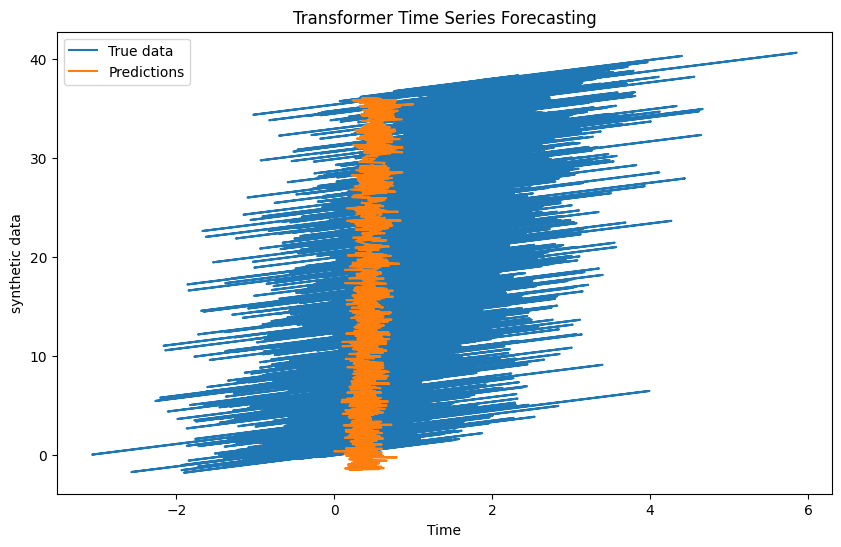

In [6]:
import os
import tensorflow as tf
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Layer, Dense, LayerNormalization, Dropout,Flatten
from keras.models import Model,Sequential
from keras import Input
import visualkeras
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import RootMeanSquaredError
from keras.callbacks import TensorBoard


gpus = tf.config.list_physical_devices('GPU')
if gpus:
	try:
		for gpu in gpus:
			tf.config.experimental.set_memory_growth(gpu,True)
		logical_gpus = tf.config.list_logical_devices('GPU')
		print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} logical GPUs')
	except RuntimeError as e:
		print(f"error setting up gpus: {e}")
else:
	print('no gpus')
class MultiHeadSelfAttention(Layer):
	def __init__(self,embed_dim,num_heads = 8):
		super(MultiHeadSelfAttention,self).__init__()
		self.embed_dim = embed_dim
		self.num_heads = num_heads
		self.projection_dim = embed_dim//num_heads
		self.query_dense = Dense(embed_dim)
		self.key_dense= Dense(embed_dim)
		self.value_dense= Dense(embed_dim)
		self.combine_heads = Dense(embed_dim)
	def attention(self,query,key,value):
		score = tf.matmul(query,key,transpose_b = True)
		dim_key = tf.cast(tf.shape(key)[-1],tf.float32)
		scaled_score = score/tf.math.sqrt(dim_key)
		weights = tf.nn.softmax(scaled_score,axis=-1)
		output = tf.matmul(weights,value)
		return output,weights
	def split_heads(self,x,batch_size):
		x = tf.reshape(x,(batch_size,-1,self.num_heads,self.projection_dim))
		return tf.transpose(x,perm=[0,2,1,3])
	def call(self,inputs):
		batch_size = tf.shape(inputs)[0]
		query = self.query_dense(inputs)
		key = self.key_dense(inputs)
		value = self.value_dense(inputs)
		query = self.split_heads(query,batch_size)
		key = self.split_heads(key,batch_size)
		value = self.split_heads(value,batch_size)
		attention_output,_=self.attention(query,key,value)
		attention_output = tf.transpose(attention_output,perm=[0,2,1,3])
		concat_attention = tf.reshape(attention_output,(batch_size,-1,self.embed_dim))
		return self.combine_heads(concat_attention)
class TransformBlock(Layer):
	def __init__(self,embed_dim,num_heads,ff_dim,rate=0.1):
		super(TransformBlock,self).__init__()
		self.att = MultiHeadSelfAttention(embed_dim,num_heads)
		self.ffn = Sequential([Dense(ff_dim,activation='relu'),Dense(embed_dim),])
		self.layernorm1 = LayerNormalization(epsilon = 1e-6)
		self.layernorm2 = LayerNormalization(epsilon=1e-6)
		self.dropout1 = Dropout(rate)
		self.dropout2 = Dropout(rate)
	def call(self,inputs,training=False):
		attn_output = self.att(inputs)
		attn_output = self.dropout1(attn_output,training=training)
		out1 = self.layernorm1(inputs+attn_output)
		ffn_output = self.ffn(out1)
		return self.layernorm2(out1+ffn_output)
class TransformerEncoder(Layer):
	def __init__(self,num_layers,embed_dim,num_heads,ff_dim,rate=0.1):
		super(TransformerEncoder,self).__init__()
		self.enc_layers = [TransformBlock(embed_dim,num_heads,ff_dim) for _ in range(num_layers)]
		self.dropout = Dropout(rate)
	def call(self,inputs,training=False):
		x = inputs
		x = self.dropout(x,training=training)
		for layer in self.enc_layers:
			x = layer(x,training=training)
		return x
def create_dataset(data,time_step=1):
	X,Y = [],[]
	for i in range(len(data)-time_step-1):
		X.append(data[i:(i+time_step)])
		Y.append(data[(i+time_step),2])
	return np.array(X),np.array(Y)
def build_model(time_step,embed_dim=128,num_heads=8,ff_dim = 512,num_layers=4,dropout_rate=0.1):
	inputs = Input(shape=(time_step,3))
	x = Dense(embed_dim)(inputs)
	encoder = TransformerEncoder(num_layers,embed_dim,num_heads,ff_dim,rate=dropout_rate)
	x = encoder(x)
	x = Flatten()(x)
	x = Dropout(dropout_rate)(x)
	outputs = Dense(1)(x)
	return Model(inputs,outputs)
	
def main():
	np.random.seed(42)
	data_length = 3000
	trend1 = np.linspace(0,365,data_length)
	trend2 = np.linspace(0,2,data_length)
	trend3 = np.linspace(0,38,data_length)
	#trend1 = np.sin(trend1)
	#trend2 = np.linspace(40,80,data_length)
	noise = np.random.normal(0,1,data_length)
	synthetic_data1 = trend1+noise
	synthetic_data2 = trend2+noise
	synthetic_data3 = trend3+noise
	df = pd.DataFrame()
	df['Time'] = synthetic_data1
	df['keff'] = synthetic_data2
	df['cr_pos'] = synthetic_data3
	
	print(df.head())
	scaler = MinMaxScaler(feature_range=(0,1))
	scaler2 = MinMaxScaler(feature_range=(0,1))
	scaled_data = scaler.fit_transform(df[['Time','keff','cr_pos']].values)
	scaled_data2 = scaler2.fit_transform(df[['cr_pos']].values)
	time_step = 100
	X,Y = create_dataset(scaled_data,time_step)
	print(X.shape,Y.shape)
	X = X.reshape((X.shape[0],X.shape[1],3))
	model = build_model(time_step,embed_dim=128,num_heads=8,ff_dim=512,num_layers=4,dropout_rate = 0.1)
	model.compile(optimizer='Adam',loss='mse',metrics=['mae',RootMeanSquaredError(name='rmse')])
	model.summary()
	logdir = os.path.join("logs",datetime.now().strftime("%Y%m%d-%H%M%S"))
	os.makedirs(logdir,exist_ok=True)
	arch_path = os.path.join(logdir,'model_visualkeras.png')
	visualkeras.layered_view(model,to_file=arch_path,legend=True,draw_volume=False,scale_xy=1.5,scale_z=1,spacing=20)
	with tf.summary.create_file_writer(logdir).as_default():
		img = tf.io.read_file(arch_path)
		img = tf.image.decode_png(img,channels=4)
		tf.summary.image("Model_visualization",tf.expand_dims(img,0),step=0)
	tensorboard_cb = TensorBoard(log_dir = logdir,histogram_freq = 1,write_graph=True,write_images=True,update_freq='epoch',profile_batch=1)
	print(f"Tensorboard logs in : {os.path.abspath(logdir)}")
	print(f"Run: tensorboard--logdir{logdir}")
	history = model.fit(X,Y,epochs=20,batch_size = 32,validation_split=0.1,callbacks = [tensorboard_cb])
	loss = model.evaluate(X,Y)
	print(X.shape)
	print("Test loss: ",loss)
	predictions = model.predict(X)
	print(predictions.shape)
	prediction = predictions.flatten()
	predictions = scaler2.inverse_transform(predictions)
	plt.figure(figsize=(10,6))
	K=X[:,98,1]
	plt.plot(df['keff'],df['cr_pos'],label='True data')
	plt.plot(K,predictions,label = 'Predictions')
	plt.title('Transformer Time Series Forecasting')
	plt.xlabel('Time')
	plt.ylabel('synthetic data')
	plt.legend()
	plot_path=os.path.join(logdir,'prediction_plot.png')
	plt.savefig(plot_path,dpi=300,bbox_inches='tight')
	print(f"Plot saved to: {plot_path}")
	
if __name__=='__main__':
	main()